In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras._tf_keras.keras.preprocessing.image import load_img, img_to_array
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
EPOCHS = 30
BATCH_SIZE = 32
IMG_SIZE = 128
IMAGE_SIZE = [128, 128]

In [ ]:
train_dir = Path('D:/PC/Documents/Tensorflow/Alzheimer Diagnosis CNN Model/Alzheimer Dataset/train')

# Get filepaths and labels
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
train_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
train_df = train_df.sample(frac=1).reset_index(drop = True)

# Show the result
train_df.head(3)

,Filepath,Label
0,D:\PC\Documents\MATLAB\Alzheimer_Diagnosis_CNN...,No Impairment
1,D:\PC\Documents\MATLAB\Alzheimer_Diagnosis_CNN...,No Impairment
2,D:\PC\Documents\MATLAB\Alzheimer_Diagnosis_CNN...,Mild Impairment


In [ ]:
test_dir = Path('D:/PC/Documents/Tensorflow/Alzheimer Diagnosis CNN Model/Alzheimer Dataset/test')

# Get filepaths and labels
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
test_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
test_df = test_df.sample(frac=1).reset_index(drop = True)

# Show the result
test_df.head(3)

,Filepath,Label
0,D:\PC\Documents\MATLAB\Alzheimer_Diagnosis_CNN...,Mild Impairment
1,D:\PC\Documents\MATLAB\Alzheimer_Diagnosis_CNN...,Mild Impairment
2,D:\PC\Documents\MATLAB\Alzheimer_Diagnosis_CNN...,No Impairment


In [26]:
train_generator = ImageDataGenerator(rescale = 1.0/255.0)

test_generator = ImageDataGenerator(rescale = 1.0/255.0)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

CLASSES = list(test_images.class_indices.keys())

Found 10240 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.


In [4]:
model = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),

    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax'),
], name = "cnn_custom_model")

model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
    )

model.summary()

Model: "cnn_custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 989,604 (3.78 MB)

 Trainable params: 988,516 (3.77 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [81]:
history = model.fit(train_images, epochs=EPOCHS, validation_data=test_images, validation_freq=1)

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - accuracy: 0.5139 - loss: 1.2046 - val_accuracy: 0.5004 - val_loss: 3.7216
Epoch 2/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - accuracy: 0.7701 - loss: 0.4971 - val_accuracy: 0.5184 - val_loss: 1.4769
Epoch 3/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.8228 - loss: 0.3989 - val_accuracy: 0.5887 - val_loss: 0.9690
Epoch 4/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.8629 - loss: 0.3001 - val_accuracy: 0.6865 - val_loss: 0.6409
Epoch 5/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8908 - loss: 0.2646 - val_accuracy: 0.6075 - val_loss: 1.0331
Epoch 6/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.9286 - loss: 0.1820 - val_accuracy: 0.6067 - val_loss: 1.1775
Epoch 7/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.9471 - loss: 0.1412 - val_accuracy: 0.8679 - val_loss: 0.3482
Epoch 8/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - accuracy: 0.9692 - loss: 0.0816 

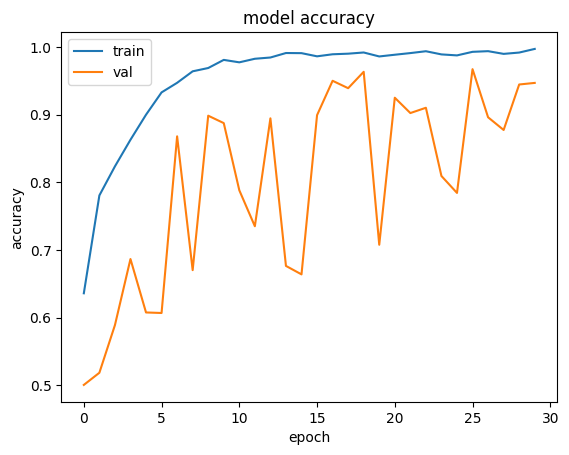

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

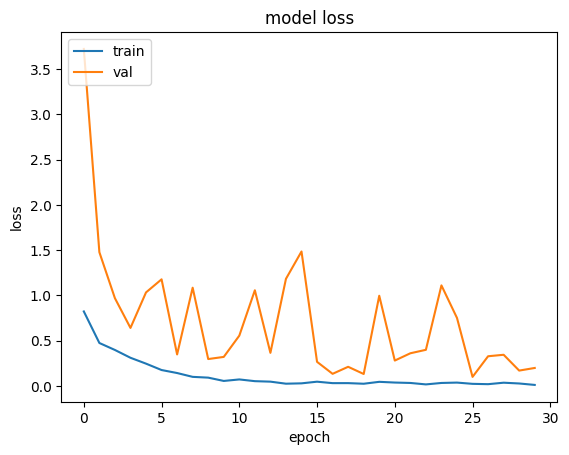

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_scores = model.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = model.predict(test_images)

def roundoff(arr):
    """Hàm này chuyển giá trị lớn nhất trong mảng truyền vào = 1, các giá trị còn lại = 0"""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9479 - loss: 0.2027
Testing Accuracy: 94.68%
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
                      precision    recall  f1-score   support

     Mild Impairment       0.88      0.99      0.93       179
 Moderate Impairment       0.86      1.00      0.92        12
       No Impairment       0.99      0.92      0.95       640
Very Mild Impairment       0.92      0.97      0.94       448

            accuracy                           0.95      1279
           macro avg       0.91      0.97      0.94      1279
        weighted avg       0.95      0.95      0.95      1279



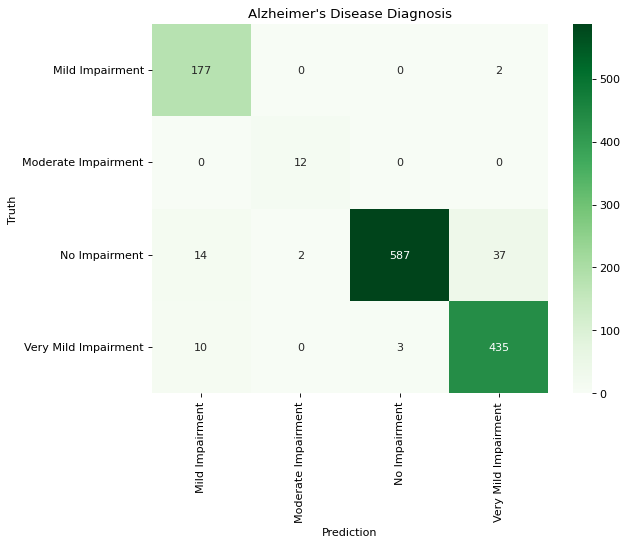

In [ ]:
# Plot the confusion matrix to understand the classification in detail
test_ls, pred_ls = test_images.classes,pred
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [94]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 96.92 %
Matthew's Correlation Coefficient: 91.56 %


In [95]:
model.save("Alzheimer_diagnosis_cnn_custom_model.h5")